# Loading packages

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, mean_squared_error, r2_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

# Loading invoice data

In [43]:
file_2022_1 = pd.read_excel('2022_1.xlsx')
file_2022_2 = pd.read_excel('2022_2.xlsx')
file_2022_3 = pd.read_excel('2022_3.xlsx')
file_2021_1 = pd.read_excel('2021_1.xlsx')
file_2021_2 = pd.read_excel('2021_2.xlsx')
file_2020_1 = pd.read_excel('2020_1.xlsx')
file_2020_2 = pd.read_excel('2020_2.xlsx')
file_2019_1 = pd.read_excel('2019_1.xlsx')
file_2019_2 = pd.read_excel('2019_2.xlsx')
file_2018 = pd.read_excel('2018.xlsx')
file_2017 = pd.read_excel('2017.xlsx')
file_2016_1 = pd.read_excel('2016_1.xlsx')
file_2016_2 = pd.read_excel('2016_2.xlsx')
file_2015_1 = pd.read_excel('2015_1.xlsx')
file_2015_2 = pd.read_excel('2015_2.xlsx')
combined_file = pd.concat([file_2022_1, file_2022_2, file_2022_3, file_2021_1, file_2021_2, file_2020_1, file_2020_2, file_2019_1,
                           file_2019_2, file_2018, file_2017, file_2016_1, file_2016_2, file_2015_1, file_2015_2], ignore_index=True)
combined_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78137 entries, 0 to 78136
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         78137 non-null  object 
 1   CustomerNo   78137 non-null  int64  
 2   BillNo       78137 non-null  int64  
 3   DueDate      78137 non-null  object 
 4   PaymentDate  78137 non-null  object 
 5   Year         78137 non-null  int64  
 6   Month        78137 non-null  int64  
 7   Delay        78137 non-null  int64  
 8   Delay1       78137 non-null  int64  
 9   OpenBill     78137 non-null  float64
 10  Late         78137 non-null  int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 6.6+ MB


# Creating new features from the data

In [44]:
combined_file['DueDate'] = pd.to_datetime(combined_file['DueDate']).dt.date
combined_file['DueDate'] = pd.to_datetime(combined_file['DueDate'])
combined_file['PaymentDate'] = pd.to_datetime(combined_file['PaymentDate']).dt.date
combined_file['PaymentDate'] = pd.to_datetime(combined_file['PaymentDate'])
# weekday of the due date
combined_file['DueDate_Weekday'] = combined_file['DueDate'].dt.day_name()
combined_file['DueDate_Weekday'] = combined_file['DueDate_Weekday'].replace({'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5,
                                                            'Saturday': 6, 'Sunday': 7})
# weekday of the payment date
combined_file['PaymentDate_Weekday'] = combined_file['PaymentDate'].dt.day_name()
combined_file['PaymentDate_Weekday'] = combined_file['PaymentDate_Weekday'].replace({'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5,
                                                            'Saturday': 6, 'Sunday': 7})
# how many days until end of month from due date
combined_file['DaysToEndOfMonth'] = combined_file['DueDate'].dt.daysinmonth - combined_file['DueDate'].dt.day
combined_file['BillCategory'] = np.where(combined_file['OpenBill'] > 0, 1, 0)
# checking the data
combined_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78137 entries, 0 to 78136
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Name                 78137 non-null  object        
 1   CustomerNo           78137 non-null  int64         
 2   BillNo               78137 non-null  int64         
 3   DueDate              78137 non-null  datetime64[ns]
 4   PaymentDate          78137 non-null  datetime64[ns]
 5   Year                 78137 non-null  int64         
 6   Month                78137 non-null  int64         
 7   Delay                78137 non-null  int64         
 8   Delay1               78137 non-null  int64         
 9   OpenBill             78137 non-null  float64       
 10  Late                 78137 non-null  int64         
 11  DueDate_Weekday      78137 non-null  int64         
 12  PaymentDate_Weekday  78137 non-null  int64         
 13  DaysToEndOfMonth     78137 non-

# Loading gasoline price data

In [45]:
gasoline_prices = pd.read_csv('gasoline_prices.csv', sep=';')
gasoline_prices.columns = ['Date', 'Diesel', '95E', '98E']
gasoline_prices['Date'] = pd.to_datetime(gasoline_prices['Date'], format='%YM%m')
gasoline_prices['Date'] = pd.to_datetime(gasoline_prices['Date']).dt.date
gasoline_prices = gasoline_prices.sort_values(by='Date')
gasoline_prices = gasoline_prices.reset_index(drop=True)
gasoline_prices['Diesel'] = gasoline_prices['Diesel'].str.replace(',', '.')
gasoline_prices['95E'] = gasoline_prices['95E'].str.replace(',', '.')
gasoline_prices['98E'] = gasoline_prices['98E'].str.replace(',', '.')
gasoline_prices = gasoline_prices.sort_values(by='Date', ascending=False)

# choosing only diesel for further analysis
diesel = gasoline_prices['Diesel']
diesel_date = gasoline_prices['Date']
diesel = pd.DataFrame({'Date': diesel_date, 'Diesel': diesel})
diesel['Month'] = pd.DatetimeIndex(diesel['Date']).month
diesel['Year'] = pd.DatetimeIndex(diesel['Date']).year
diesel = diesel.drop(['Date'], axis=1)
# show the first 5 rows
print(diesel.head())

    Diesel  Month  Year
248   2.16      9  2022
247   2.09      8  2022
246   2.27      7  2022
245   2.44      6  2022
244   2.27      5  2022


# Loading euribor interest rates data

In [46]:
euribor = pd.read_excel('Euribor_12-22.xlsx')
euribor.columns = ['Date', '1kk', '3kk','12kk']
euribor['Date'] = pd.to_datetime(euribor['Date'], format='%YM%m')
euribor['Date'] = pd.to_datetime(euribor['Date']).dt.date
euribor = euribor.sort_values(by='Date')
euribor = euribor.reset_index(drop=True)

# creating a vector of the values in 12kk column including month and year
euribor_12kk = euribor['12kk']
euribor12_date = euribor['Date']
euribor_12kk = pd.DataFrame({'Date': euribor12_date, '12kk': euribor_12kk})
euribor_12kk['Month'] = pd.DatetimeIndex(euribor_12kk['Date']).month
euribor_12kk['Year'] = pd.DatetimeIndex(euribor_12kk['Date']).year
euribor_12kk = euribor_12kk.drop(['Date'], axis=1)

combined_file['Month'] = pd.DatetimeIndex(combined_file['DueDate']).month
combined_file['Year'] = pd.DatetimeIndex(combined_file['DueDate']).year
combined_file = pd.merge(combined_file, diesel, on=['Month', 'Year'], how='left')
combined_file = pd.merge(combined_file, euribor_12kk, on=['Month', 'Year'], how='left')

combined_file = combined_file.drop(['Month', 'Year'], axis=1)
combined_file = combined_file.fillna(0)
combined_file['Diesel'] = combined_file['Diesel'].astype(float)
combined_file = combined_file[(combined_file['DueDate'] >= '2015-01-01') & (combined_file['DueDate'] <= '2022-09-01')]
combined_file = combined_file.reset_index(drop=True)
combined_file = combined_file[['Late','BillCategory', 'DueDate_Weekday', 'DaysToEndOfMonth', 'Delay', 'PaymentDate_Weekday', 'OpenBill', 'Diesel', '12kk', 'DueDate']]
# adding column log_diesel with the natural logarithm of the diesel price
combined_file['log_diesel'] = np.log(combined_file['Diesel'])

combined_file = combined_file.drop(['Diesel'], axis=1)
combined_file = combined_file.drop(['BillCategory'], axis=1)

print(combined_file.isnull().sum())
print(combined_file.shape)
print(list(combined_file.columns))

Late                   0
DueDate_Weekday        0
DaysToEndOfMonth       0
Delay                  0
PaymentDate_Weekday    0
OpenBill               0
12kk                   0
DueDate                0
log_diesel             0
dtype: int64
(76850, 9)
['Late', 'DueDate_Weekday', 'DaysToEndOfMonth', 'Delay', 'PaymentDate_Weekday', 'OpenBill', '12kk', 'DueDate', 'log_diesel']


# Data Quality and Variable Relationships for Classification

In [47]:
describe = combined_file.describe()
rounded = describe.round(1)
print(rounded)

          Late  DueDate_Weekday  DaysToEndOfMonth    Delay  \
count  76850.0          76850.0           76850.0  76850.0   
mean       0.5              4.1              15.2      5.8   
std        0.5              1.6               8.2     39.2   
min        0.0              1.0               0.0   -259.0   
25%        0.0              3.0               8.0      0.0   
50%        0.0              5.0              17.0      0.0   
75%        1.0              5.0              21.0      4.0   
max        1.0              7.0              30.0   2114.0   

       PaymentDate_Weekday  OpenBill     12kk  log_diesel  
count              76850.0   76850.0  76850.0     76850.0  
mean                   3.3    1423.8     -0.1         0.3  
std                    1.7    3061.8      0.3         0.2  
min                    1.0    -624.0     -0.5         0.1  
25%                    2.0       0.0     -0.3         0.2  
50%                    3.0      74.8     -0.2         0.3  
75%                  

In [48]:
combined_file.head()

,Late,DueDate_Weekday,DaysToEndOfMonth,Delay,PaymentDate_Weekday,OpenBill,12kk,DueDate,log_diesel
0,0,5,20,0,5,0.0,-0.237391,2022-03-11,0.845868
1,0,5,10,0,5,0.0,-0.335250,2022-02-18,0.625938
2,0,1,14,0,1,0.0,-0.335250,2022-02-14,0.625938
3,0,1,14,0,1,0.0,-0.335250,2022-02-14,0.625938
4,1,5,17,4,2,0.0,-0.476667,2022-01-14,0.576613


# Checking if the data is balanced

0    39292
1    37558
Name: Late, dtype: int64


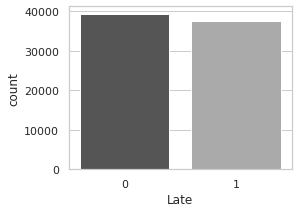

Percentage of Late is 49.0
Percentage of not Late is 51.0


In [49]:
print(combined_file['Late'].value_counts())
plt.figure(figsize=(4, 3))
sns.countplot(x='Late', data=combined_file, palette='gray')
plt.show()
count_late = len(combined_file[combined_file['Late']==1])
count_not_late = len(combined_file[combined_file['Late']==0])
pct_of_late = count_late/(count_late+count_not_late)
rounded_pct = round(pct_of_late, 2)
print("Percentage of Late is", rounded_pct*100)
pct_of_not_late = count_not_late/(count_late+count_not_late)
rounded_not_pct = round(pct_of_not_late, 2)
print("Percentage of not Late is", rounded_not_pct*100)

It looks like the data is fairly balanced, with approximately equal proportions of "Late" and "not Late" observations.

## Correlation heatmap

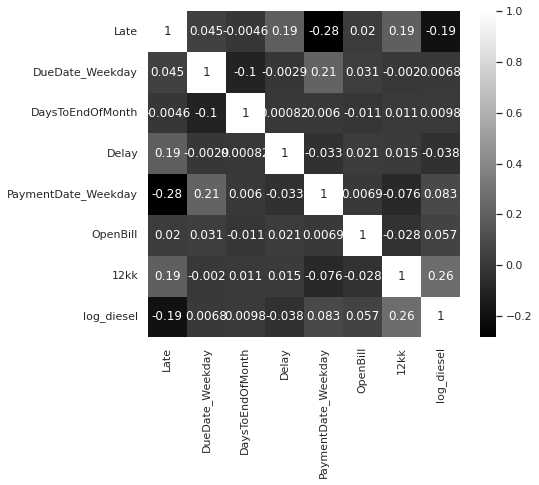

In [53]:
corr = combined_file.corr()
plt.figure(figsize=(7, 6))
sns.heatmap(corr, annot=True, cmap='gray')
plt.show()

There are no strong correlations between the variables, and therefore multicollinearity is less likely to be an issue.

## Pairplot

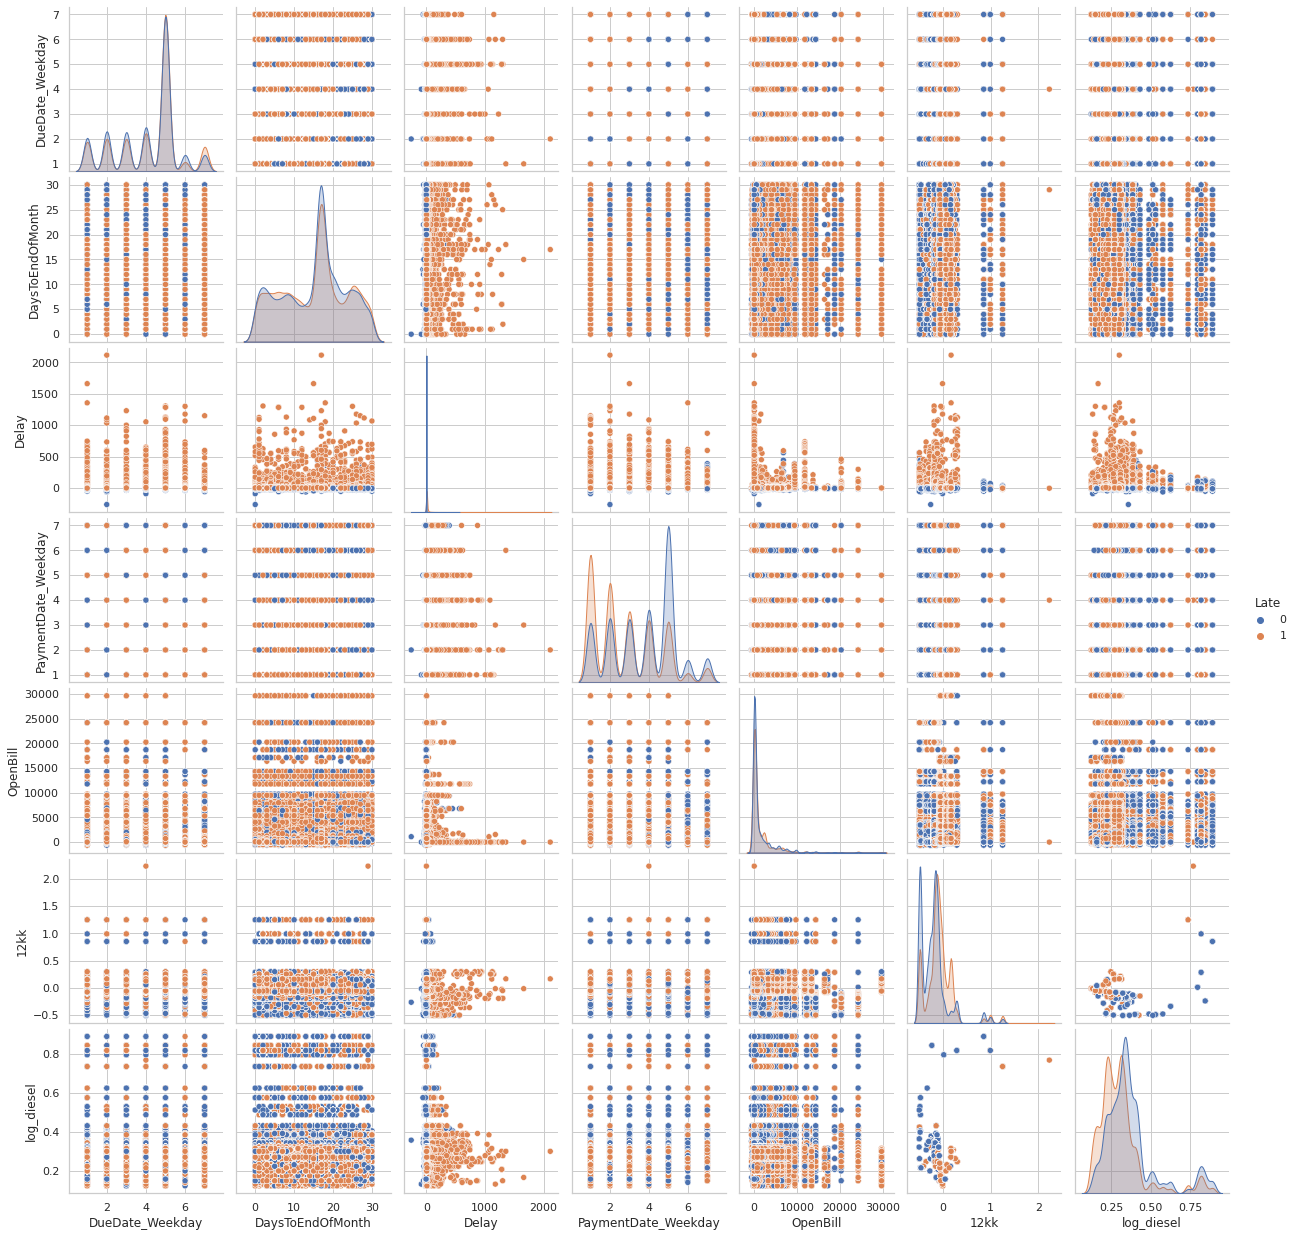

In [54]:
# pairplot with the independent variables and the label (Late)
sns.pairplot(combined_file, hue='Late')
plt.rcParams['figure.figsize'] = (7, 7)
plt.show()

# Logistic regression model

The data will be split in 70:30 training and tests sets.

In [55]:
X = combined_file.drop(['Late', 'DueDate'], axis=1)
y = combined_file['Late']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print('Train size: ', X_train.shape, y_train.shape)
print('Test size: ', X_test.shape, y_test.shape)
print('Train set:')
print(y_train.value_counts())
print('Test set:')
print(y_test.value_counts())

Train size:  (53795, 7) (53795,)
Test size:  (23055, 7) (23055,)
Train set:
0    27500
1    26295
Name: Late, dtype: int64
Test set:
0    11792
1    11263
Name: Late, dtype: int64


Scaling the data to make it more balanced.

In [56]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [57]:
print('Train size: ', X_train_scaled.shape, y_train.shape)
print('Test size: ', X_test_scaled.shape, y_test.shape)
print('Train set:')
print(y_train.value_counts())
print('Test set:')
print(y_test.value_counts())

Train size:  (53795, 7) (53795,)
Test size:  (23055, 7) (23055,)
Train set:
0    27500
1    26295
Name: Late, dtype: int64
Test set:
0    11792
1    11263
Name: Late, dtype: int64


Implementing the model

In [58]:
clf = LogisticRegression(max_iter=10e5)
clf.fit(X_train_scaled, y_train)
val_pred = clf.predict(X_test_scaled)
val_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]

print('Logistic Regression evaluation metrics')
print('Accuracy: ', round(accuracy_score(y_test, val_pred), 2))
print('Precision: ', round(precision_score(y_test, val_pred), 2))
print('Recall: ', round(recall_score(y_test, val_pred), 2))
print('F1: ', round(f1_score(y_test, val_pred), 2))
print('Log loss: ', round(log_loss(y_test, val_pred_proba), 2))
print('ROC AUC: ', round(roc_auc_score(y_test, val_pred_proba), 2))
print('R2 score: ', round(r2_score(y_test, val_pred_proba), 2))
print('Mean squared error: ', round(mean_squared_error(y_test, val_pred_proba), 2))

Logistic Regression evaluation metrics
Accuracy:  0.93
Precision:  0.98
Recall:  0.88
F1:  0.93
Log loss:  0.26
ROC AUC:  0.98
R2 score:  0.75
Mean squared error:  0.06


# k-Nearest Neighbours Model

Splitting the data into training and testing sets.

In [59]:
X = combined_file.drop(['Late', 'DueDate'], axis=1)
y = combined_file['Late']

# Split the data into train and test sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.3, random_state=42)

# Print the shape of the train and test sets
print("The shape of train and test sets")
print('Train size: ', X_train2.shape, y_train2.shape)
print('Test size: ', X_test2.shape, y_test2.shape)
print()

print("The class distribution in the train set")
print('Train set:')
print(y_train2.value_counts())
print()
print("The class distribution in the test set")
print('Test set:')
print(y_test2.value_counts())

The shape of train and test sets
Train size:  (53795, 7) (53795,)
Test size:  (23055, 7) (23055,)

The class distribution in the train set
Train set:
0    27531
1    26264
Name: Late, dtype: int64

The class distribution in the test set
Test set:
0    11761
1    11294
Name: Late, dtype: int64


Scaling the data

In [60]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train2)
X_test_scaled = scaler.transform(X_test2)

Running k-NN model

In [61]:
# Creating KNN classifier
knn = KNeighborsClassifier()

# cross validation to evaluate the model's performance
scores = cross_val_score(knn, X_train_scaled, y_train2, cv=49)
print(scores)

[0.91165756 0.92440801 0.90346084 0.90983607 0.90801457 0.90801457
 0.8989071  0.88979964 0.91712204 0.90983607 0.90346084 0.91621129
 0.90528233 0.90619308 0.91530055 0.90255009 0.91256831 0.91256831
 0.90528233 0.92258652 0.90437158 0.90710383 0.92440801 0.92440801
 0.91803279 0.90983607 0.9143898  0.90255009 0.91074681 0.90801457
 0.91074681 0.91712204 0.91074681 0.90710383 0.91347905 0.89526412
 0.90983607 0.91621129 0.91165756 0.91256831 0.91165756 0.91347905
 0.92160438 0.90701914 0.90793072 0.91613491 0.91431176 0.91157703
 0.90519599]


## KNN Classifier Performance vs Number of Neighbors

Accuracy vs. number of neighbors

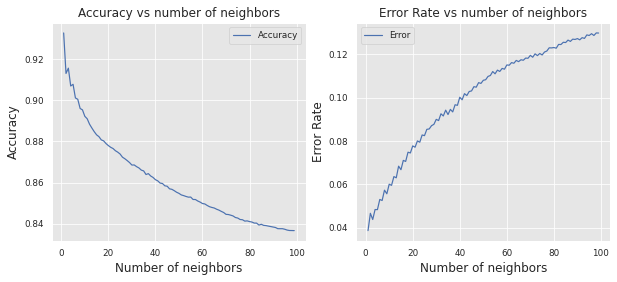

In [62]:
# List of possible values for k
sns.set_context("paper")
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
k_values = range(1, 100)

# First subplot (accuracy)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
accuracy_scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train2, cv=10)
    accuracy_scores.append(scores.mean())

plt.plot(k_values, accuracy_scores, linestyle='solid')
plt.xlabel('Number of neighbors', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy vs number of neighbors', fontsize=12)
plt.legend(['Accuracy'])

# Second subplot (loss)
plt.subplot(1, 2, 2)
error_rate = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.plot(k_values, error_rate, linestyle='solid')
plt.xlabel('Number of neighbors', fontsize=12)
plt.ylabel('Error Rate', fontsize=12)
plt.title('Error Rate vs number of neighbors', fontsize=12)
plt.legend(['Error'])

plt.show()

## Evaluating the Performance of a KNN Classifier

In [63]:
knn = KNeighborsClassifier(n_neighbors=277)
knn.fit(X_train2, y_train2)
val_pred_knn = knn.predict(X_test2)
val_pred_proba_knn = knn.predict_proba(X_test2)[:, 1]

print('KNN, k=277')
print('Accuracy: ', accuracy_score(y_test2, val_pred_knn))
print('Precision: ', precision_score(y_test2, val_pred_knn))
print('Recall: ', recall_score(y_test2, val_pred_knn))
print('F1: ', f1_score(y_test2, val_pred_knn))
print('ROC AUC: ', roc_auc_score(y_test2, val_pred_proba_knn))
print('Kappa score: ', cohen_kappa_score(y_test2, val_pred_knn))

KNN, k=277
Accuracy:  0.8179136846671005
Precision:  0.8722980062959077
Recall:  0.7360545422348149
F1:  0.7984056857472147
ROC AUC:  0.9147362008283539
Kappa score:  0.6345446319365422


In [64]:
knn2 = KNeighborsClassifier(n_neighbors=3)
knn2.fit(X_train2, y_train2)
val_pred_kn2 = knn2.predict(X_test2)
val_pred_proba_knn2 = knn2.predict_proba(X_test2)[:, 1]

print('KNN, k=3')
print('Accuracy: ', accuracy_score(y_test2, val_pred_kn2))
print('Precision: ', precision_score(y_test2, val_pred_kn2))
print('Recall: ', recall_score(y_test2, val_pred_kn2))
print('F1: ', f1_score(y_test2, val_pred_kn2))
print('ROC AUC: ', roc_auc_score(y_test2, val_pred_proba_knn2))
print('Kappa score: ', cohen_kappa_score(y_test2, val_pred_kn2))

KNN, k=3
Accuracy:  0.9542832357406202
Precision:  0.9679217693291903
Recall:  0.9377545599433328
F1:  0.9525993883792049
ROC AUC:  0.976067678247991
Kappa score:  0.9084723050638863


# Confusion matrix for Logistic Regression model and kNN model

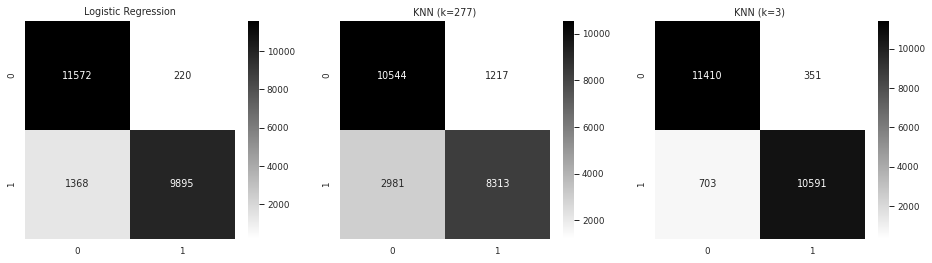

In [65]:
confusion_matrix(y_test, val_pred)
confusion_matrix(y_test2, val_pred_knn)
confusion_matrix(y_test2, val_pred_kn2)
sns.set_context("paper")

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
sns.heatmap(confusion_matrix(y_test, val_pred), annot=True, fmt='d', ax=ax[0], cmap='binary')
ax[0].set_title('Logistic Regression')
sns.heatmap(confusion_matrix(y_test2, val_pred_knn), annot=True, fmt='d', ax=ax[1], cmap='binary')
ax[1].set_title('KNN (k=277)')
sns.heatmap(confusion_matrix(y_test2, val_pred_kn2), annot=True, fmt='d', ax=ax[2], cmap='binary')
ax[2].set_title('KNN (k=3)')

plt.show()

## ROC curves

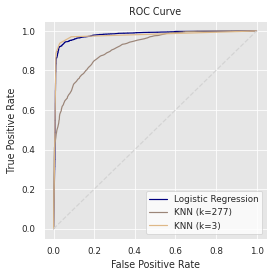

In [67]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("paper")
roc_auc_score(y_test, val_pred_proba)

roc_auc_score(y_test2, val_pred_proba_knn)
roc_auc_score(y_test2, val_pred_proba_knn2)

fpr, tpr, thresholds = roc_curve(y_test, val_pred_proba)
fpr2, tpr2, thresholds2 = roc_curve(y_test2, val_pred_proba_knn)
fpr3, tpr3, thresholds3 = roc_curve(y_test2, val_pred_proba_knn2)
plt.figure(figsize=(4, 4))

plt.plot(fpr, tpr, label='Logistic Regression', color = 'navy')
plt.plot(fpr2, tpr2, label='KNN (k=277)', color='#9B8578')
plt.plot(fpr3, tpr3, label='KNN (k=3)', color='burlywood')

plt.plot([0, 1], [0, 1], 'k--', color='lightgrey')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right', facecolor='white')
plt.show()

- kNN model with k=3 has the best overall performance, followed by the logistic regression model. 
- The kNN model with k=277 has the lowest performance among the three models. 
- While the kNN model with k=3 may be more sensitive to patterns in the data and at risk of overfitting, it appears to be a trade-off worth making in this case, considering the model's overall performance. 
- Therefore, these results suggest that carefully tuning the value of hyperparameter k in the kNN model can improve the model's performance.